In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
from tqdm import notebook
from re import compile
from utils.regex_fx import remove_single_char, remove_numbers, remove_urls, remove_emojis, remove_extra_spaces, remove_rt, remove_nonalpha, remove_mention, strip_list_noempty
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### Latex formatting for plots

In [3]:
plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [4]:
pan_dataset = pd.read_pickle('all_collected_users_en')
true = pan_dataset[pan_dataset['claim_label']=='true']
false = pan_dataset[pan_dataset['claim_label']=='false']

In [5]:
pan_dataset[pan_dataset['source']=='politifact']

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
1275297,politifact,@bobmooreim,true,1,"\n""Only 12% of legal immigrants are selected b...",/bobmooreim/status/1137722294858539008,7:05 AM - 9 Jun 2019,"#DonaldTrump,#ImmigrationReform #Immigration, ..."
1275298,politifact,@statesman,true,1,"\n""Only 12% of legal immigrants are selected b...",/statesman/status/1133416551028338688,9:55 AM - 28 May 2019,"Trump said, “Only 12% of legal immigrants are ..."
1275299,politifact,@penelope7usa,true,1,"\n""Only 12% of legal immigrants are selected b...",/penelope7usa/status/1129248526796578816,9:53 PM - 16 May 2019,Hate to be the bearer of continuous bad news:\...
1275300,politifact,@PolitiFact,false,4,"\n""In America today, women on average are paid...",/PolitiFact/status/1141769683789668352,11:08 AM - 20 Jun 2019,.@KamalaHarris said during a @colbertlateshow ...
1275301,politifact,@tscott1998,false,7,"\n""How to Survive The Coming Ice Age"" was a Ti...",/tscott1998/status/1131631212202741760,11:41 AM - 23 May 2019,"Viral image: ""How to Survive The Coming Ice Ag..."
...,...,...,...,...,...,...,...,...
1756436,politifact,@kklass,true,12877,"\n""We now have the greatest income inequality ...",/kklass/status/909770836235755520,6:27 AM - 18 Sep 2017,Shame GOP doesn't respect providing for the ge...
1756437,politifact,@galactiicactus,true,12877,"\n""We now have the greatest income inequality ...",/galactiicactus/status/882072182171377664,8:02 PM - 3 Jul 2017,income inequality the greatest it has been sin...
1756438,politifact,@seiu1021,true,12877,"\n""We now have the greatest income inequality ...",/seiu1021/status/553260577997725696,10:42 AM - 8 Jan 2015,At a time of the greatest income inequality si...
1756439,politifact,@JohnFugelsang,true,12877,"\n""We now have the greatest income inequality ...",/JohnFugelsang/status/529736078425878528,12:44 PM - 4 Nov 2014,#Imnotvoting b/c we've got the greatest income...


### The amount of fake and false news for each source

In [6]:
true.source.value_counts()

gossipcop     958667
politifact    141210
snopes         54450
emergent        7764
Name: source, dtype: int64

In [7]:
false.source.value_counts()

politifact               339934
snopes                   254580
gossipcop                176307
leadstories-anastasia    132356
emergent                    203
Name: source, dtype: int64

In [8]:
politifact_true = true[true.source=='politifact']
politifact_false = false[false.source=='politifact']
gossipcop_true = true[true.source =='gossipcop']
gossipcop_false = false[false.source =='gossipcop']

In [9]:
len(politifact_true.claim_id.unique())

1468

In [10]:
# politifact_true.to_csv('pan_politifact_true.csv')
# politifact_false.to_csv('pan_politifact_false.csv')
# gossipcop_true.to_csv('pan_gossipcop_true.csv')
# gossipcop_false.to_csv('pan_gossipcop_false.csv')

In [11]:
gossipcop_false.sort_values('claim_text').head(5)

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
1086882,gossipcop,@GossipCop,false,19146,Kendall Kylie Jenner Jenner NOT Upset Up...,/GossipCop/status/995423424741888001,3:00 PM - 12 May 2018,"Kendall, Kylie Jenner NOT ""Upset"" Over Caitlyn..."
1055307,gossipcop,@GossipCop,false,18122,Kim Kardashian Dethroned Dethroned By Khlo...,/GossipCop/status/849030801970868224,3:48 PM - 3 Apr 2017,"Kim Kardashian ""Dethroned"" By Khloe As ""Hot"" S..."
1133130,gossipcop,@bestdivorcesoln,false,20268,Kim Kardashian Did NOT Hot Staffer Hot Sta...,/bestdivorcesoln/status/977921622672920576,7:54 AM - 25 Mar 2018,Kim Kardashian Did NOT Fire “Hot Staffer” To “...
1133131,gossipcop,@SullivanDelvin,false,20268,Kim Kardashian Did NOT Hot Staffer Hot Sta...,/SullivanDelvin/status/942711426115829760,3:01 AM - 18 Dec 2017,Kim Kardashian Did NOT Fire “Hot Staffer” To “...
1133133,gossipcop,@GossipCop,false,20268,Kim Kardashian Did NOT Hot Staffer Hot Sta...,/GossipCop/status/940396081715826688,5:41 PM - 11 Dec 2017,"Kim Kardashian Did NOT Fire ""Hot Staffer"" To ""..."


### Date formatting for PAN dataset
- `%I` hour 12-hour clock as a decimal (no zero padding)
- `:` separation between hour and minute
- `%M` minute as a zero padded decimal
- `%p` AM/PM
- ` - ` space-dash-space pattern betwen time and date 
- `%d` date of the month as a decimal (no zero padding)
- `%b` Month abbreviated
- `%Y` Year with century as decimal

In [12]:
def dfDateTimeFormat(df):
    formatted_dates = []
    for item in df.tweet_date:
        formatted_dates.append(datetime.strptime(item, "%I:%M %p - %d %b %Y"))
    df.tweet_date = formatted_dates
    df.sort_values(['claim_id','tweet_date'], ascending=[True, True], inplace=True)
    return df

In [13]:
gossipcop_false = dfDateTimeFormat(gossipcop_false)
gossipcop_true = dfDateTimeFormat(gossipcop_true)
politifact_false = dfDateTimeFormat(politifact_false)
politifact_true = dfDateTimeFormat(politifact_true)

In [14]:
gossipcop_false.head(2)

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
966714,gossipcop,@TheLoopAu,false,15967,Did Miley Cyrus and Liam Hemsworth secretly ge...,/TheLoopAu/status/700137152143699968,2016-02-17 17:57:00,"UM, did @MileyCyrus and @LiamHemsworth just se..."
966713,gossipcop,@ReadUnwritten,false,15967,Did Miley Cyrus and Liam Hemsworth secretly ge...,/ReadUnwritten/status/700501642412560384,2016-02-18 18:06:00,"Wait, Did Miley Cyrus And Liam Hemsworth Secre..."


In [15]:
def createDeltaTimeCols(df):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item]['deltaT'] = tweet_groups[item].tweet_date.diff().astype('timedelta64[s]', errors='raise')
        tweet_groups[item].fillna(0, inplace=True)
    return tweet_groups

In [16]:
politifact_false_tweet_groups = createDeltaTimeCols(politifact_false)
politifact_true_tweet_groups = createDeltaTimeCols(politifact_true)
gossipcop_false_tweet_groups = createDeltaTimeCols(gossipcop_false)
gossipcop_true_tweet_groups = createDeltaTimeCols(gossipcop_true)

In [17]:
HOUR_IN_SECONDS = 3600
DAY_IN_SECONDS = 24*HOUR_IN_SECONDS
WEEK_IN_SECONDS = 7*DAY_IN_SECONDS

### Switch last two ifs to `elif` for the cumulative values

In [18]:
def calculateVirality(tweet_groups):
    results = {}
    tweets_shared_in_less_than_an_hour = 0
    tweets_shared_in_less_than_a_day = 0
    tweets_shared_in_less_than_a_week = 0
    for item in tweet_groups:
        results[item] = tweet_groups[item]['tweet_date'].to_list()
        for index, timestamp in enumerate(results[item]):
            if index+1 < len(results[item]):
                # calculate difference between first tweet and every other tweet
                difference = results[item][index] - results[item][0]
                # extract times 
                days = difference.days
                seconds = difference.seconds
                hours = seconds//3600
                minutes = (seconds//60)%60
                # took less than an hour
                if days == 0 and hours == 0 and minutes < 60:
                    tweets_shared_in_less_than_an_hour+=1
                # took less than a day
                if days == 0 and hours < 24 and days == 0:
                    tweets_shared_in_less_than_a_day+=1
                # took less than a week
                if days < 7:
                    tweets_shared_in_less_than_a_week+=1
    return tweets_shared_in_less_than_an_hour, tweets_shared_in_less_than_a_day, tweets_shared_in_less_than_a_week

In [19]:
pf_less_than_an_hour, pf_less_than_a_day, pf_less_than_a_week = calculateVirality(politifact_false_tweet_groups)
pt_less_than_an_hour, pt_less_than_a_day, pt_less_than_a_week = calculateVirality(politifact_true_tweet_groups)
gf_less_than_an_hour, gf_less_than_a_day, gf_less_than_a_week = calculateVirality(gossipcop_false_tweet_groups)
gt_less_than_an_hour, gt_less_than_a_day, gt_less_than_a_week = calculateVirality(gossipcop_true_tweet_groups)


In [20]:
gt_less_than_a_week

477048

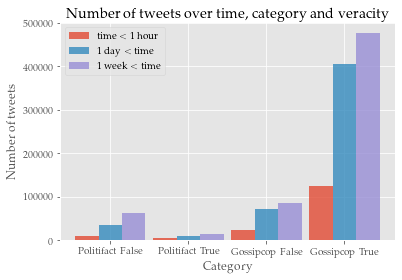

In [21]:
n_groups = 4
hour = (pf_less_than_an_hour, pt_less_than_an_hour, gf_less_than_an_hour, gt_less_than_an_hour)
day = (pf_less_than_a_day, pt_less_than_a_day, gf_less_than_a_day, gt_less_than_a_day)
week = (pf_less_than_a_week, pt_less_than_a_week, gf_less_than_a_week, gt_less_than_a_week)

# create plot
fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, hour, bar_width,
alpha=opacity,
# color='b',
label=r'time $<$ 1 hour ')

rects2 = plt.bar(index + bar_width, day, bar_width,
alpha=opacity,
# color='g',
label=r'1 day $<$ time')

rects3 = plt.bar(index + bar_width + bar_width, week, bar_width,
alpha=opacity,
# color='r',
label=r'1 week  $<$ time')

plt.xlabel('Category')
plt.ylabel('Number of tweets')
plt.title('Number of tweets over time, category and veracity')
plt.xticks(index + bar_width, ('Politifact False', 'Politifact True', 'Gossipcop False', 'Gossipcop True'))
plt.legend()

# plt.tight_layout()
plt.show()

In [22]:
def calculateBuckets(tweet_groups):
    results = {}
    tweet_buckets = {}
    tweets_shared_in_less_than_an_hour = 0
    tweets_shared_in_less_than_a_day = 0
    tweets_shared_in_less_than_a_week = 0
    for item in tweet_groups:
        hour_count = 0
        quarter_count = 0
        results[item] = tweet_groups[item]['tweet_date'].to_list()
        # article level
        for index, timestamp in enumerate(results[item]):
            if index+1 < len(results[item]):
                # calculate difference between first tweet and every other tweet
                difference = results[item][index] - results[item][0]
                
                # extract times 
                days = difference.days
                seconds = difference.seconds
                hours = seconds//3600
                minutes = (seconds//60)%60
                

                total_minutes = hours*60 + days*24*60 + minutes
                # took less than an hour
                # if days == 0 and hours < hour_count and minutes < 60:
                if total_minutes < quarter_count*5:
                    try:
                        tweet_buckets[quarter_count] += 1
                    except KeyError:
                        tweet_buckets[quarter_count] = 1
            quarter_count+=1
            # hour_count+=1
              
    return tweet_buckets

In [23]:
gossipcop_true_buckets = calculateBuckets(gossipcop_true_tweet_groups)
gossipcop_false_buckets = calculateBuckets(gossipcop_false_tweet_groups)
politifact_true_buckets = calculateBuckets(politifact_true_tweet_groups)
politifact_false_buckets = calculateBuckets(politifact_false_tweet_groups)


In [24]:
# politifact_true_buckets

In [25]:
def createHourBucket(df):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item]['hours'] = tweet_groups[item]['tweet_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()\
            .cumsum().div(60*60).astype(int)
        # tweet_groups[item].set_index('tweet_date').resample('30min').count()
    return tweet_groups

In [26]:
def createCumulativeIntervalBucket(df, interval):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item][f'{interval}_minutes_cumulative'] = tweet_groups[item]['tweet_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()\
            .cumsum().div(60*interval).astype(int)
        # tweet_groups[item].set_index('tweet_date').resample('30min').count()
    return tweet_groups

In [27]:
def createIntervalBucket(df, interval):
    delta = 'h'
    if interval == 60:
        delta = 'h'
    elif interval == 1:
        delta = 'm'

    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item][f'{interval}_minutes_delta'] = tweet_groups[item]['tweet_date'].diff().astype(f'timedelta64[{delta}]', errors='raise')
        tweet_groups[item].fillna(0, inplace=True)
        # tweet_groups[item].set_index('tweet_date').resample('30min').count()
    return tweet_groups

In [28]:
politifact_true_minutes = createIntervalBucket(politifact_true, 1)
# politifact_false_minutes = createIntervalBucket(politifact_false, 1)
# gossipcop_true_minutes = createIntervalBucket(gossipcop_true, 1)
# gossipcop_false_minutes = createIntervalBucket(gossipcop_false, 1)


In [29]:
politifact_true_minutes['group_1']

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text,1_minutes_delta
1275299,politifact,@penelope7usa,true,1,"\n""Only 12% of legal immigrants are selected b...",/penelope7usa/status/1129248526796578816,2019-05-16 21:53:00,Hate to be the bearer of continuous bad news:\...,0.0
1275298,politifact,@statesman,true,1,"\n""Only 12% of legal immigrants are selected b...",/statesman/status/1133416551028338688,2019-05-28 09:55:00,"Trump said, “Only 12% of legal immigrants are ...",16562.0
1275297,politifact,@bobmooreim,true,1,"\n""Only 12% of legal immigrants are selected b...",/bobmooreim/status/1137722294858539008,2019-06-09 07:05:00,"#DonaldTrump,#ImmigrationReform #Immigration, ...",17110.0


In [30]:
politifact_true_hours_cumulative = createCumulativeIntervalBucket(politifact_true, 60)


In [31]:
politifact_true_hour_delta = createIntervalBucket(politifact_true, 60)
politifact_false_hour_delta = createIntervalBucket(politifact_false, 60)
gossipcop_true_hour_delta = createIntervalBucket(gossipcop_true, 60)
gossipcop_false_hour_delta = createIntervalBucket(gossipcop_false, 60)


In [32]:
politifact_true_minute_delta = createIntervalBucket(politifact_true, 1)
politifact_false_minute_delta = createIntervalBucket(politifact_false, 1)
gossipcop_true_minute_delta = createIntervalBucket(gossipcop_true, 1)
gossipcop_false_minute_delta = createIntervalBucket(gossipcop_false, 1)


In [33]:
politifact_true_hour_delta['group_1']

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text,60_minutes_delta
1275299,politifact,@penelope7usa,true,1,"\n""Only 12% of legal immigrants are selected b...",/penelope7usa/status/1129248526796578816,2019-05-16 21:53:00,Hate to be the bearer of continuous bad news:\...,0.0
1275298,politifact,@statesman,true,1,"\n""Only 12% of legal immigrants are selected b...",/statesman/status/1133416551028338688,2019-05-28 09:55:00,"Trump said, “Only 12% of legal immigrants are ...",276.0
1275297,politifact,@bobmooreim,true,1,"\n""Only 12% of legal immigrants are selected b...",/bobmooreim/status/1137722294858539008,2019-06-09 07:05:00,"#DonaldTrump,#ImmigrationReform #Immigration, ...",285.0


In [34]:
politifact_true_hour_delta['group_15'].iloc[:,-1:].sum()

60_minutes_delta    28005.0
dtype: float64

In [35]:
politifact_true_minute_delta['group_1']

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text,1_minutes_delta
1275299,politifact,@penelope7usa,true,1,"\n""Only 12% of legal immigrants are selected b...",/penelope7usa/status/1129248526796578816,2019-05-16 21:53:00,Hate to be the bearer of continuous bad news:\...,0.0
1275298,politifact,@statesman,true,1,"\n""Only 12% of legal immigrants are selected b...",/statesman/status/1133416551028338688,2019-05-28 09:55:00,"Trump said, “Only 12% of legal immigrants are ...",16562.0
1275297,politifact,@bobmooreim,true,1,"\n""Only 12% of legal immigrants are selected b...",/bobmooreim/status/1137722294858539008,2019-06-09 07:05:00,"#DonaldTrump,#ImmigrationReform #Immigration, ...",17110.0


In [36]:
def calculateArticleVirality(df):
    nr_tweets_for_article = len(df)
    total_time = df.iloc[:,-1:].sum()
    article_virality = total_time/nr_tweets_for_article
    return article_virality

### We can pass in a single article and calculate the virality as the time it took for the `n` tweets to occur

In [37]:
calculateArticleVirality(politifact_true_hour_delta['group_15'])

60_minutes_delta    345.740741
dtype: float64

In [38]:
def calculateDfVirality(df):
    # print(len(df))
    articles_virality = 0
    for item in df:
        single_article_virality = calculateArticleVirality(df[item])
        single_article_virality = single_article_virality/len(df[item])
        # print(item,':', single_article_virality)
        if int(single_article_virality) < 61:
            articles_virality+=single_article_virality
    print(articles_virality)
    return articles_virality


In [39]:
politifact_true_minute_delta['group_1']

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text,1_minutes_delta
1275299,politifact,@penelope7usa,true,1,"\n""Only 12% of legal immigrants are selected b...",/penelope7usa/status/1129248526796578816,2019-05-16 21:53:00,Hate to be the bearer of continuous bad news:\...,0.0
1275298,politifact,@statesman,true,1,"\n""Only 12% of legal immigrants are selected b...",/statesman/status/1133416551028338688,2019-05-28 09:55:00,"Trump said, “Only 12% of legal immigrants are ...",16562.0
1275297,politifact,@bobmooreim,true,1,"\n""Only 12% of legal immigrants are selected b...",/bobmooreim/status/1137722294858539008,2019-06-09 07:05:00,"#DonaldTrump,#ImmigrationReform #Immigration, ...",17110.0


In [40]:
pf_true_virality = calculateDfVirality(politifact_true_minute_delta)
pf_false_virality = calculateDfVirality(politifact_false_minute_delta)
gp_true_virality = calculateDfVirality(gossipcop_true_minute_delta)
gp_false_virality = calculateDfVirality(gossipcop_false_minute_delta)

1_minutes_delta    3124.304064
dtype: float64
1_minutes_delta    9129.926985
dtype: float64
1_minutes_delta    89660.326758
dtype: float64
1_minutes_delta    29986.674809
dtype: float64


# Number of tweets for articles inside df

In [41]:
def calculateNumberOfTweetsForArticle(df):
    article_shares_length = []
    for item in df:
        nr_tweets_for_article = len(df[item])
        article_shares_length.append(nr_tweets_for_article)

    #     single_article_virality = calculateArticleVirality()
    #     single_article_virality = single_article_virality/len(df[item])
    #     # print(item,':', single_article_virality)
    #     if int(single_article_virality) < 61:
    #         articles_virality+=single_article_virality
    # print(articles_virality)
    # return articles_virality
    return article_shares_length

In [42]:
pf_true_nr_tweets_for_article = calculateNumberOfTweetsForArticle(politifact_true_minute_delta)
pf_false_nr_tweets_for_article = calculateNumberOfTweetsForArticle(politifact_false_minute_delta)
gp_true_nr_tweets_for_article = calculateNumberOfTweetsForArticle(gossipcop_true_minute_delta)
gp_false_nr_tweets_for_article = calculateNumberOfTweetsForArticle(gossipcop_false_minute_delta)

In [43]:
pf_true_nr_tweets_for_article = [number for number in pf_true_nr_tweets_for_article if number < 200 and number > 0]
pf_false_nr_tweets_for_article = [number for number in pf_false_nr_tweets_for_article if number < 200 and number > 0]
gp_true_nr_tweets_for_article = [number for number in gp_true_nr_tweets_for_article if number < 200 and number > 0]
gp_false_nr_tweets_for_article = [number for number in gp_false_nr_tweets_for_article if number < 200 and number > 0]


In [44]:
def outlierDetection(arr):
    print("Before outlier detection and removal:")
    print(stats.describe(arr))
    array = np.array(arr)
    mean = np.mean(array)
    standard_deviation = np.std(array)
    distance_from_mean = abs(array - mean)
    max_deviations = 0.16
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    no_outliers = array[not_outlier]
    print("After outlier detection and removal:")
    print(stats.describe(no_outliers))
    return no_outliers

In [45]:
# pf_true_nr_tweets_for_article = outlierDetection(pf_true_nr_tweets_for_article)
# pf_false_nr_tweets_for_article = outlierDetection(pf_false_nr_tweets_for_article)
# gp_true_nr_tweets_for_article = outlierDetection(gp_true_nr_tweets_for_article)
# gp_false_nr_tweets_for_article = outlierDetection(gp_false_nr_tweets_for_article)

In [46]:
# print(sum(i > 200 and  is not i0 for i in pf_true_nr_tweets_for_article)/len(pf_true_nr_tweets_for_article))
# print(sum(i > 200 and i != 0 for i in pf_false_nr_tweets_for_article)/len(pf_false_nr_tweets_for_article))
# print(sum(i > 200 and i != 0 for i in gp_true_nr_tweets_for_article)/len(gp_true_nr_tweets_for_article))
# print(sum(i > 200 and i != 0 for i in gp_false_nr_tweets_for_article)/len(gp_false_nr_tweets_for_article))


11129

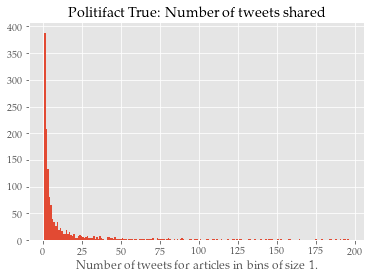

In [47]:
_ = plt.hist(pf_true_nr_tweets_for_article, bins=200)  # arguments are passed to np.histogram
title = "Politifact True: Number of tweets shared"
x_label = "Number of tweets for articles in bins of size 1."
plt.xlabel(x_label)

plt.title(title)
plt.show()

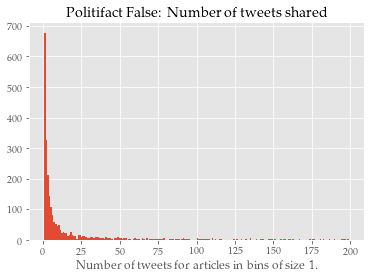

In [48]:
_ = plt.hist(pf_false_nr_tweets_for_article, bins=200)  # arguments are passed to np.histogram
title = "Politifact False: Number of tweets shared"
x_label = "Number of tweets for articles in bins of size 1."
plt.xlabel(x_label)

plt.title(title)
plt.show()

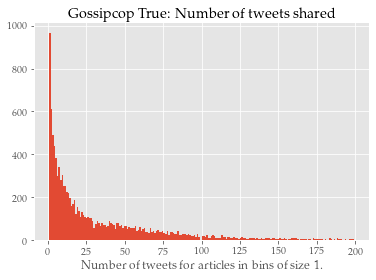

In [49]:
_ = plt.hist(gp_true_nr_tweets_for_article, bins=200)  # arguments are passed to np.histogram
title = "Gossipcop True: Number of tweets shared"
x_label = "Number of tweets for articles in bins of size 1."
plt.xlabel(x_label)

plt.title(title)
plt.show()

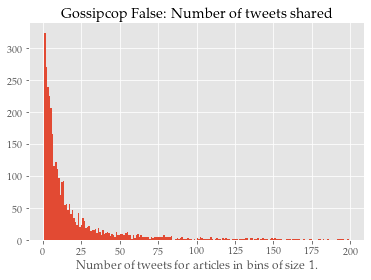

In [50]:
_ = plt.hist(gp_false_nr_tweets_for_article, bins=200)  # arguments are passed to np.histogram
title = "Gossipcop False: Number of tweets shared"
x_label = "Number of tweets for articles in bins of size 1."
plt.xlabel(x_label)

plt.title(title)
plt.show()

In [51]:
gp_false_virality

1_minutes_delta    29986.674809
dtype: float64

In [52]:
def collectArticleViralitiesForDf(df):
    # print(len(df))
    b_300_500 = 0
    print(len(df))
    zero_count = []
    to_examine = []
    articles_virality = []
    for item in df:
        single_article_virality = calculateArticleVirality(df[item])
        single_article_virality = single_article_virality/len(df[item])
        # print(int(single_article_virality))
        # print(item,':', single_article_virality)
        if int(single_article_virality) == 0:
            zero_count.append(str(item))
        elif int(single_article_virality) < 200:
            # print(articles_virality)
            articles_virality.append(int(single_article_virality))
        else:
            to_examine.append(str(item))
    return zero_count, to_examine, articles_virality


In [53]:
# sorted_pf_true = sorted(collectArticleViralitiesForDf(politifact_true_minute_delta))
# sorted_pf_false = sorted(collectArticleViralitiesForDf(politifact_false_minute_delta))
# sorted_gp_true = sorted(collectArticleViralitiesForDf(gossipcop_true_minute_delta))
# sorted_gp_false = sorted(collectArticleViralitiesForDf(gossipcop_false_minute_delta))

In [54]:
zero_count_pf_true, removed_pf_true, article_viralities_pf_true = collectArticleViralitiesForDf(politifact_true_minute_delta)
zero_count_pf_false, removed_pf_false, article_viralities_pf_false = collectArticleViralitiesForDf(politifact_false_minute_delta)
zero_count_gp_true, removed_gp_true, article_viralities_gp_true = collectArticleViralitiesForDf(gossipcop_true_minute_delta)
zero_count_gp_false, removed_gp_false, article_viralities_gp_false = collectArticleViralitiesForDf(gossipcop_false_minute_delta)

1468
2745
11838
3412


In [55]:
print(len(zero_count_pf_true))
print(len(removed_pf_true))
print(len(article_viralities_pf_true))
print(len(zero_count_pf_true) + len(removed_pf_true) + len(article_viralities_pf_true) )

433
776
259
1468


In [56]:
article_viralities_pf_true[:10]

[159, 35, 2, 3, 2, 126, 55, 121, 101, 38]

In [57]:
sorted_pf_true = list(filter((0).__ne__, article_viralities_pf_true))
sorted_pf_false = list(filter((0).__ne__, article_viralities_pf_false))
sorted_gp_true = list(filter((0).__ne__, article_viralities_gp_true))
sorted_gp_false = list(filter((0).__ne__, article_viralities_gp_false))

In [58]:
# # sorted_pf_true = [number for number in sorted_pf_true if number < 62000]
sorted_pf_false = [number for number in sorted_pf_false if number < 200]
sorted_pf_true = [number for number in sorted_pf_true if number < 200]
sorted_gp_true = [number for number in sorted_gp_true if number < 200]
sorted_gp_false = [number for number in sorted_gp_false if number < 200]


In [59]:
len(sorted_gp_true)

7211

In [60]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import pylab as pl

In [61]:
# data = sorted(sorted_pf_true)
# sorted_pf_true

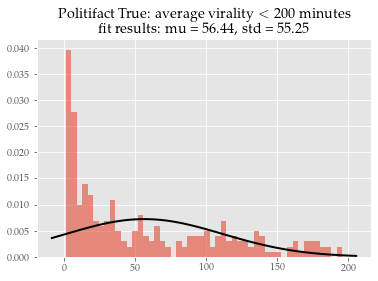

In [62]:
data_pf_true = sorted(sorted_pf_true)
mu, std = norm.fit(data_pf_true)

# Plot the histogram.
plt.hist(data_pf_true, bins=50, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Politifact True: average virality $< 200 $ minutes \n fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

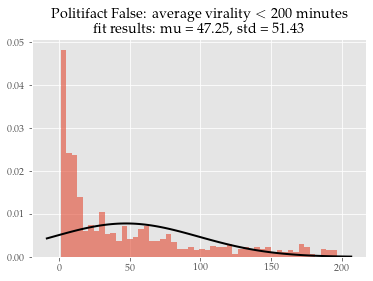

In [65]:
data_pf_false = sorted(data_pf_false)
mu, std = norm.fit(data_pf_false)
# Plot the histogram.
plt.hist(data_pf_false, bins=50, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Politifact False: average virality $< 200 $ minutes \n fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

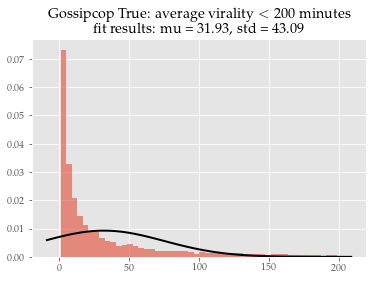

In [66]:
data_gp_true = sorted(sorted_gp_true)
mu, std = norm.fit(data_gp_true)

# Plot the histogram.
plt.hist(data_gp_true, bins=50, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Gossipcop True: average virality $< 200 $ minutes \n fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

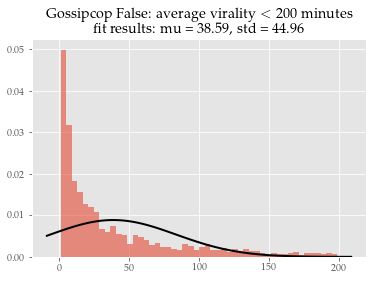

In [67]:
data_gp_false = sorted(sorted_gp_false)
mu, std = norm.fit(data_gp_false)

# Plot the histogram.
plt.hist(data_gp_false, bins=50, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Gossipcop False: average virality $< 200 $ minutes \n fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [71]:
stat, p = stats.shapiro(data_pf_true)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.862, p=0.000
Sample does not look Gaussian (reject H0)


In [72]:
k2, p = stats.normaltest(data_pf_true)
alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.50277e-07
The null hypothesis can be rejected


In [420]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(sorted_pf_false, sorted_pf_true,  alternative='two-sided')
print(p)
U1, p = mannwhitneyu(sorted_pf_true, sorted_gp_true, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(sorted_pf_true, sorted_gp_false, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(sorted_gp_true, sorted_pf_false, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(sorted_pf_false, sorted_gp_false, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(sorted_gp_true, sorted_gp_false, alternative='two-sided')
print(p)


0.017162113210046945
1.0388204871147646e-15
2.8055999033775485e-06
1.8960747180459236e-17
0.0024097772380569328
2.698829373593667e-21


In [421]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(pf_true_nr_tweets_for_article, pf_false_nr_tweets_for_article, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(pf_true_nr_tweets_for_article, gp_true_nr_tweets_for_article, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(pf_true_nr_tweets_for_article, gp_false_nr_tweets_for_article, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(pf_false_nr_tweets_for_article, gp_true_nr_tweets_for_article,  alternative='two-sided')
print(p)
U1, p = mannwhitneyu(pf_false_nr_tweets_for_article, gp_false_nr_tweets_for_article, alternative='two-sided')
print(p)
U1, p = mannwhitneyu(gp_false_nr_tweets_for_article, gp_true_nr_tweets_for_article, alternative='two-sided')
print(p)

# U1, p = mannwhitneyu(gp_true_nr_tweets_for_article, gp_false_nr_tweets_for_article, alternative='two-sided')
# print(p)

0.012371901344964886
3.121012431263065e-168
3.6100240458527445e-61
1.665520662324711e-203
1.765480496366705e-55
1.7993614817761014e-89
